In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.feature_selection import f_classif
from tensorflow.keras.optimizers import SGD

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv("/content/drive/MyDrive/DADES_TFM_SECTORS.csv",sep=';', encoding='ISO-8859-1')
df.shape

(1032318, 11)

In [ ]:
x = df[['Any observat ','Antiguitat','length','matcat_id','pnom','dnom','Fallades anteriors','Fallades anteriors en el mateix sector']]
y = df[['fallada']]

In [ ]:
campo_division = 'Any observat '

In [ ]:
x_entrenamiento = x[x['Any observat ']< 2016]
y_entrenamiento = y[y.index.isin(x_entrenamiento.index)]

In [ ]:
x_validacion = x[x['Any observat '] >= 2016]
y_validacion = y[y.index.isin(x_validacion.index)]

In [ ]:
columnas_seleccionadas = ['Antiguitat','length','matcat_id','pnom','dnom','Fallades anteriors','Fallades anteriors en el mateix sector']
x_def = x[columnas_seleccionadas]
x_validacion_def = x_validacion[columnas_seleccionadas]
x_entrenamiento_def = x_entrenamiento[columnas_seleccionadas]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_entrenamiento_def = scaler.fit_transform(x_entrenamiento_def)
x_validacion_def = scaler.transform(x_validacion_def)

In [ ]:
modelo = keras.Sequential()
modelo.add(keras.layers.Dense(units=128,activation='relu', input_shape=(x_entrenamiento_def.shape[1],)),)
modelo.add(keras.layers.Dropout(rate=0.3))
modelo.add(keras.layers.Dense(units=128,activation='relu'))
modelo.add(keras.layers.Dropout(rate=0.3))
modelo.add(keras.layers.Dense(units=1,activation='sigmoid'))

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
historia = modelo.fit(x_entrenamiento_def, y_entrenamiento, epochs= 20, batch_size=32, validation_split=0.2)

Epoch 1/20
2982/2982 [==============================] - 11s 3ms/step - loss: 0.0701 - accuracy: 0.9910 - val_loss: 0.0551 - val_accuracy: 0.9907
Epoch 2/20
2982/2982 [==============================] - 9s 3ms/step - loss: 0.0368 - accuracy: 0.9938 - val_loss: 0.0536 - val_accuracy: 0.9907
Epoch 3/20
2982/2982 [==============================] - 8s 3ms/step - loss: 0.0358 - accuracy: 0.9938 - val_loss: 0.0521 - val_accuracy: 0.9907
Epoch 4/20
2982/2982 [==============================] - 9s 3ms/step - loss: 0.0351 - accuracy: 0.9938 - val_loss: 0.0517 - val_accuracy: 0.9907
Epoch 5/20
2982/2982 [==============================] - 8s 3ms/step - loss: 0.0350 - accuracy: 0.9939 - val_loss: 0.0522 - val_accuracy: 0.9907
Epoch 6/20
2982/2982 [==============================] - 12s 4ms/step - loss: 0.0346 - accuracy: 0.9938 - val_loss: 0.0518 - val_accuracy: 0.9907
Epoch 7/20
2982/2982 [==============================] - 8s 3ms/step - loss: 0.0342 - accuracy: 0.9939 - val_loss: 0.0517 - val_accurac

In [ ]:
y_pred_prob = modelo.predict(x_validacion_def)
y_pred_classes = np.round(y_pred_prob).flatten()

1917/1917 [==============================] - 3s 1ms/step


In [ ]:
weights_input_layer = modelo.layers[0].get_weights()[0]
from sklearn.feature_selection import f_classif
f_values, _ = f_classif(x_entrenamiento_def, y_entrenamiento)
importance_df = pd.DataFrame({'Variable': x_def.columns[:9], 'Importancia': f_values})
importance_df = importance_df.sort_values(by='Importancia', ascending=False)
print(importance_df)

                                 Variable  Importancia
5                      Fallades anteriors  1645.892883
1                                  length   924.647428
6  Fallades anteriors en el mateix sector   344.704361
3                                    pnom   103.053239
4                                    dnom    96.058518
0                              Antiguitat    61.113069
2                               matcat_id     0.020527


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
thresholds = [0.005]

In [ ]:
for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    y_pred_classes = np.round(y_pred).flatten()

In [ ]:
accuracy = accuracy_score(y_validacion, y_pred_classes)
conf_matrix = confusion_matrix(y_validacion, y_pred_classes)


In [ ]:
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy:.2f}")
    print(conf_matrix)
    print("\n")

Threshold: 0.005
Accuracy: 0.75
[[45917 15181]
 [   42   179]]




In [ ]:
P=conf_matrix[1]
N=conf_matrix[0]
VP=P[1]
FN=P[0]
VN=N[0]
FP=N[1]

In [ ]:
sensibilidad = VP / (VP + FN)
especificidad = VN / (VN + FP)
exactitud = (VP + VN) / conf_matrix.sum()

In [ ]:
print("Sensibilidad:",sensibilidad)
print("Especificidad:" ,especificidad)
print("Exactitud:", exactitud)

Sensibilidad: 0.8099547511312217
Especificidad: 0.7515303283249861
Exactitud: 0.751740895970254


In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr, tpr, thresholds = roc_curve(y_validacion, y_pred_classes)
roc_auc = auc(fpr, tpr)

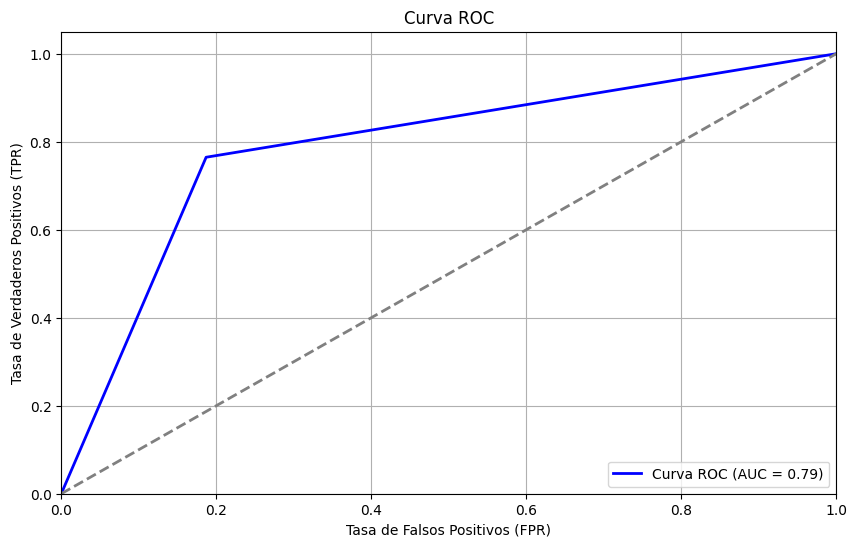

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()